## Support Vector Machines Classifier 

This notebook contains the SVN classifier on the collected data.

Table of Content:
* **1. Import required packages**
* **2. Import files**
* **3. Undersampling the majority class**
* **4. Word Frequency**
* 4.1 Bag of Words
* 4.2 TF-IDF
* **5. Support Vector Machines**
* 5.1 Define the target and explanatory variable, cross validation
* 5.2 Build the model with Sklearn pipeline
* 5.3 Evaluation of the model 
* *5.3.1 Modell Accuracy*
* *5.3.2 Confusion Matrix*
* *5.3.3 ROC curve*
* **6. Iterable modell building**

### 1. Import required packages

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix, roc_curve, roc_auc_score

### 2. Import files

In [2]:
abt_covid = pd.read_pickle('C:/Users/molna/Desktop/Szakdolgozat/adatok/abt_covid_featured.pkl')

print("ABT table has {} rows and {} columns".format(len(abt_covid), len(abt_covid.columns)))

ABT table has 63631 rows and 75 columns


In [4]:
# select only the relevant features for the modelling
data = abt_covid[["dezinf", "title_lemmas", "text_lemmas"]]

### 3. Undersampling the majority class

In [5]:
class_count_0, class_count_1 = data['dezinf'].value_counts()

In [6]:
class_0 = data[data['dezinf'] == 0]
class_1 = data[data['dezinf'] == 1]
print('class 0:', class_0.shape)
print('class 1:', class_1.shape)

class 0: (50356, 3)
class 1: (13275, 3)


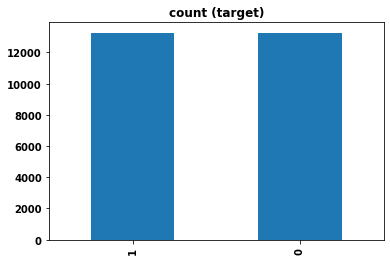

In [7]:
class_0_under = class_0.sample(class_count_1)

data_under = pd.concat([class_0_under, class_1], axis=0)

data_under['dezinf'].value_counts().plot(kind='bar', title='count (target)')

### 4. Word Frequency

In [8]:
def dummy(doc):
    return doc

#### 4.1 Bag of Words

In [9]:
count_vect = CountVectorizer(tokenizer=dummy, preprocessor=dummy,)

In [10]:
word_count_matrix = count_vect.fit_transform(data_under["text_lemmas"])

In [11]:
word_count_matrix

<26550x192724 sparse matrix of type '<class 'numpy.int64'>'
	with 3876166 stored elements in Compressed Sparse Row format>

#### 4.2 TF-IDF
(i.e Term Frequency times inverse document frequency)

In [12]:
tf_idf = TfidfTransformer()
tf_idf.fit(word_count_matrix)
tf_idf.idf_

array([10.49367551,  6.8827576 ,  9.10738115, ..., 10.49367551,
       10.49367551, 10.49367551])

In [13]:
idf = pd.DataFrame(tf_idf.idf_, index=count_vect.get_feature_names(), columns=['idf_weight'])
idf.sort_values(by='idf_weight')

C:\Users\molna\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,idf_weight
koronavírus,1.290460
járvány,1.503047
ember,1.894718
tud,1.928264
ország,2.066298
...,...
kj,10.493676
kiűzés,10.493676
kişin,10.493676
kladus,10.493676


### 5.  Support Vector Machines (SVN)

#### 5.1 Define the target and explanatory variable, cross validation

In [37]:
X = data_under['text_lemmas']
y = data_under['dezinf']

In [38]:
# split data into 80% training and 20% test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#### 5.2 Build the model with Sklearn pipeline

In [43]:
svm_pipe = Pipeline([('vector', CountVectorizer(tokenizer=dummy,
                                                preprocessor=dummy)),
                         ('tfidf', TfidfTransformer()),
                         ('clf-svm', SGDClassifier(loss='hinge', 
                                                   alpha=1e-3))
                        ])

In [44]:
svm_model = svm_pipe.fit(X_train, y_train)

#### 5.3 Evaluation of the model

#### 5.3.1 Modell Accuracy

In [29]:
predicted = svm_model.predict(X_test)

score = round(svm_model.score(X_test, y_test), 2)

print("The Accuracy of the naive bayes model on the article text is: {} % with the balanced dataset".format(score))

The Accuracy of the naive bayes model on the article text is: 0.83 % with the balanced dataset


#### 5.3.2 Confusion Matrix

              precision    recall  f1-score   support

           0       0.86      0.81      0.83      2689
           1       0.81      0.86      0.84      2621

    accuracy                           0.83      5310
   macro avg       0.84      0.83      0.83      5310
weighted avg       0.84      0.83      0.83      5310

Failure first row (%):  24.03 %
Failure second row (%):  15.92 %


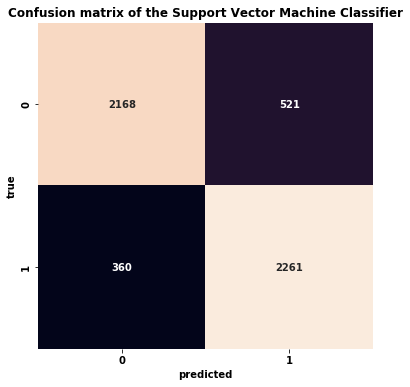

In [36]:
cm = confusion_matrix(y_test, predicted)
plt.figure(figsize = (6,6))
sns.heatmap(cm, annot=True, cbar=False, fmt="g")
plt.title('Confusion matrix of the Support Vector Machine Classifier')
plt.xlabel("predicted")
plt.ylabel("true")

print(classification_report(y_test, predicted))

print("Failure first row (%): ", round(confusion_matrix(y_test, predicted)[0,1]/confusion_matrix(y_test, predicted)[0,0]*100,2),"%")
print("Failure second row (%): ", round(confusion_matrix(y_test, predicted)[1,0]/confusion_matrix(y_test, predicted)[1,1]*100,2),"%")

plt.show()

#### 5.3.3 ROC curve

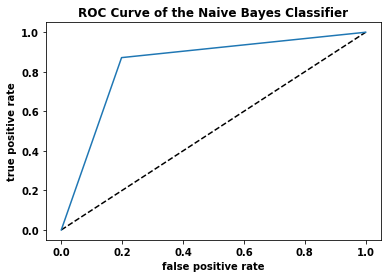

The AUC score of the Naive Bayes Classifier: 0.84


In [24]:
fpr, tpr, thresholds = roc_curve(y_test, predicted)

# plot the diagonal line
plt.plot([0,1],[0,1],'k--') 
# plot the ROC curve
plt.plot(fpr, tpr, label='NB') 
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('ROC Curve of the Naive Bayes Classifier')
plt.show()

print("The AUC score of the Naive Bayes Classifier: {}".format(round(roc_auc_score(y_test, predicted), 2)))

In [21]:
prediction = svm_model.predict(data_under['text_lemmas'])

In [22]:
data_under["prediction"] = prediction

In [23]:
data_under.head()

,dezinf,title_lemmas,text_lemmas,prediction
"""44530""",0,"[odafigyel, rendszeres, vízfogyasztás, tél]","[víz, kulcsfontosságú, szerep, lát, szervezet,...",1
"""19096""",0,"[örmény, kormányfő, foglalkozik, álhírterjesztő]","[örmény, kormány, helyi, televízió, közvetítet...",0
"""44049""",0,"[meghalad, millió, európa, koronavírus, fertőz...","[megduplázódik, európa, koronavírus, fertőzött...",0
"""40577""",0,"[számos, európai, ország, an, astrazeneca]","[spanyolország, jövő, szerda, alkalmaz, astraz...",0
"""18611""",0,"[szijjártó, péter, megnyílik, magyar, horvát, ...","[megnyílhat, magyar, horvát, határ, karantén, ...",0


### 6. Iterable modell building

In [46]:
iter = 20

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['model_runs', 'fpr', 'tpr', 'acc', 'auc'])

for i in range(0, iter): 
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) # , random_state=42
    
    svm_pipe = Pipeline([('vector', CountVectorizer(tokenizer=dummy,
                                                preprocessor=dummy)),
                         ('tfidf', TfidfTransformer()),
                         ('clf-svm', SGDClassifier(loss='hinge', 
                                                   alpha=1e-3))
                        ])
    
    svm_model = svm_pipe.fit(X_train, y_train)    
    
    predicted = svm_model.predict(X_test)
    
    #yproba = svm_model.predict_proba(X_test)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test,  predicted)

    acc = round(svm_pipe.score(X_test, y_test), 6)
    
    auc = round(roc_auc_score(y_test, predicted), 6)
    
    result_table = result_table.append({'model_runs': i,
                                        'fpr': fpr, 
                                        'tpr': tpr, 
                                        'acc': acc,
                                        'auc':auc},
                                       ignore_index=True)


# Set name of the classifiers as index labels
result_table.set_index('model_runs', inplace=True)

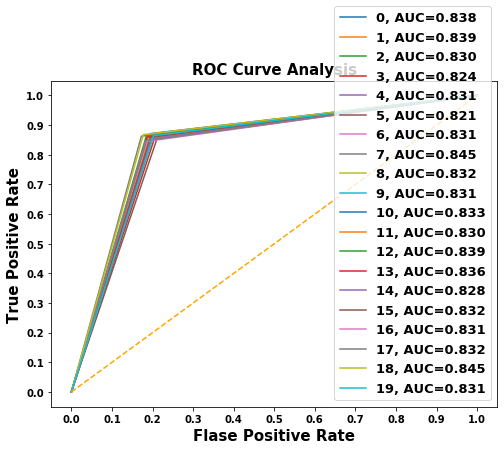

In [52]:
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

In [53]:
# mean AUC score of 100 runs
print(result_table['auc'].mean())

0.8330257
